In [0]:
import keras
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation
from keras.models import Model
from keras.metrics import top_k_categorical_accuracy, categorical_accuracy
from keras.engine.topology import get_source_inputs
from keras.layers import DepthwiseConv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10 
from keras import optimizers,regularizers
import numpy as np
from skimage.transform import resize
from keras import models
from keras import layers
import matplotlib.pyplot as plt
import os

In [0]:
#base setup
batch_size = 64
num_classes = 10
epochs = 20
num_predictions = 20
weight_decay=1e-4

In [0]:
def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    return x_train, x_test

def scheduler(epoch):
    if epoch < 100:
        return 0.01
    if epoch < 200:
        return 0.001
    return 0.0001

# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)
x_train, x_test = color_preprocessing(x_train, x_test)

In [0]:
def depthwise_separable(x,params):
    # f1/f2 filter size, s1 stride of conv
    (s1,f2) = params
    x = DepthwiseConv2D((3,3),strides=(s1[0],s1[0]), padding='same',depthwise_initializer="he_normal")(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Conv2D(int(f2[0]), (1,1), strides=(1,1), padding='same',
               kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    return x

In [0]:
def MobileNet(img_input, alpha=1, shallow=False, classes=10):
    
    x = Conv2D(int(32), (3,3), strides=(2,2), padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = depthwise_separable(x,params=[(1,),(64,)])
    x = depthwise_separable(x,params=[(2,),(128,)])
    x = depthwise_separable(x,params=[(1,),(128,)])
    x = depthwise_separable(x,params=[(2,),(256,)])
    x = depthwise_separable(x,params=[(1,),(256,)])
    x = depthwise_separable(x,params=[(2,),(512,)])
    
    if not shallow:
        for _ in range(5):
            x = depthwise_separable(x,params=[(1,),(512,)])
            
    x = depthwise_separable(x,params=[(2,),(1024,)])
    x = depthwise_separable(x,params=[(1,),(1024,)])

    x = GlobalAveragePooling2D()(x)
    out = Dense(classes, activation='softmax')(x)
    return out

In [57]:
img_input=Input(shape=(32,32,3))
output = MobileNet(img_input)
model=Model(img_input,output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_82 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_82 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d_40 (Depthwi (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_83 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_83 (Activation)   (None, 16, 16, 32)        0         
__________

In [58]:
# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

# start training
history = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
model.save('mobilenet.h5')

Epoch 1/20
781/781 [==============================] - 57s 72ms/step - loss: 4.4269 - acc: 0.2546 - val_loss: 5.2385 - val_acc: 0.2255
Epoch 2/20
781/781 [==============================] - 46s 59ms/step - loss: 5.8940 - acc: 0.1884 - val_loss: 6.7874 - val_acc: 0.1550
Epoch 3/20
781/781 [==============================] - 46s 59ms/step - loss: 6.1332 - acc: 0.1816 - val_loss: 5.6011 - val_acc: 0.2137
Epoch 4/20
781/781 [==============================] - 46s 59ms/step - loss: 4.8584 - acc: 0.2461 - val_loss: 4.5720 - val_acc: 0.2912
Epoch 5/20
781/781 [==============================] - 47s 60ms/step - loss: 3.9788 - acc: 0.2963 - val_loss: 3.7960 - val_acc: 0.3218
Epoch 6/20
781/781 [==============================] - 46s 59ms/step - loss: 3.3458 - acc: 0.3349 - val_loss: 3.2876 - val_acc: 0.3604
Epoch 7/20
781/781 [==============================] - 47s 60ms/step - loss: 2.8994 - acc: 0.3587 - val_loss: 2.7700 - val_acc: 0.3755
Epoch 8/20
781/781 [==============================] - 46s 59ms

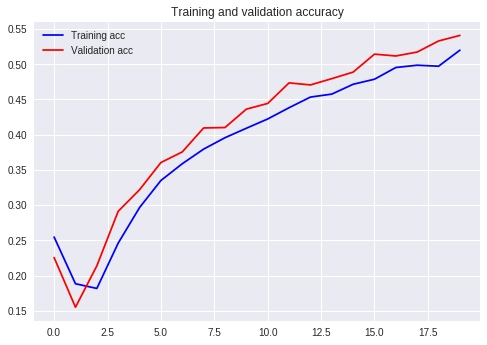

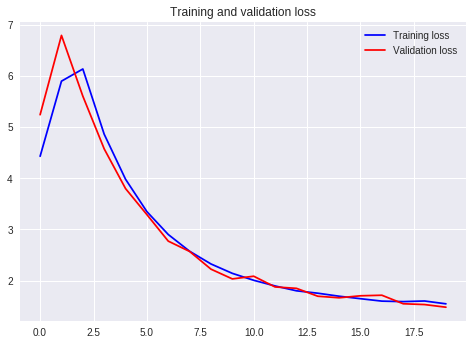

In [59]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [60]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 4s 388us/step
Test loss: 1.4796258668899536
Test accuracy: 0.5409


In [0]:
# Transfer Learning

# add a global spatial average pooling layer
x = model.output
# x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# and a logistic layer -- 10 classes for CIFAR10
predictions = Dense(num_classes, activation='softmax')(x)

In [62]:
# this is the model we will train
model_trans = Model(inputs=model.input, outputs=predictions)
model_trans.summary()
for i,layer in enumerate(model_trans.layers):
  print(i,layer.name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_82 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_82 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d_40 (Depthwi (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_83 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_83 (Activation)   (None, 16, 16, 32)        0         
__________

In [63]:
# set optimizer

model_trans.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

# start training
history = model_trans.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
model_trans.save('mobilenet_transferLearning.h5')

Epoch 1/20
781/781 [==============================] - 61s 78ms/step - loss: 1.8651 - acc: 0.4117 - val_loss: 1.7431 - val_acc: 0.4794
Epoch 2/20
781/781 [==============================] - 51s 65ms/step - loss: 1.7747 - acc: 0.4633 - val_loss: 1.7227 - val_acc: 0.4823
Epoch 3/20
781/781 [==============================] - 50s 64ms/step - loss: 1.7260 - acc: 0.4729 - val_loss: 1.6032 - val_acc: 0.5219
Epoch 4/20
781/781 [==============================] - 50s 63ms/step - loss: 1.7092 - acc: 0.4794 - val_loss: 1.6336 - val_acc: 0.5003
Epoch 5/20
781/781 [==============================] - 49s 63ms/step - loss: 1.6898 - acc: 0.4858 - val_loss: 1.5913 - val_acc: 0.5168
Epoch 6/20
781/781 [==============================] - 49s 63ms/step - loss: 1.7383 - acc: 0.4725 - val_loss: 1.6230 - val_acc: 0.5228
Epoch 7/20
781/781 [==============================] - 49s 63ms/step - loss: 1.7038 - acc: 0.4864 - val_loss: 1.6628 - val_acc: 0.5035
Epoch 8/20
781/781 [==============================] - 49s 63ms

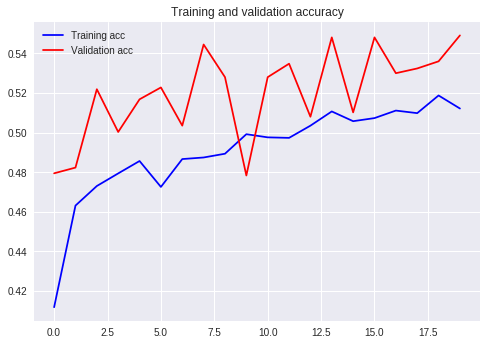

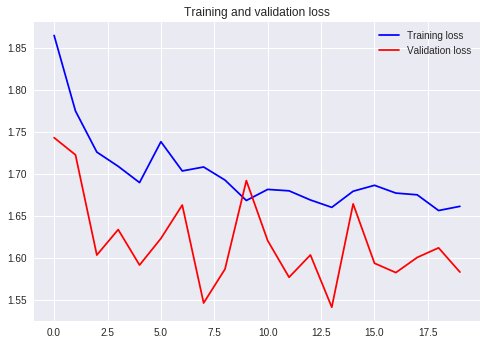

In [64]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [65]:
scores = model_trans.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 4s 395us/step
Test loss: 1.582895671272278
Test accuracy: 0.5491


In [66]:
#Fine Tuning
# we should freeze:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_4
1 conv2d_43
2 batch_normalization_82
3 activation_82
4 depthwise_conv2d_40
5 batch_normalization_83
6 activation_83
7 conv2d_44
8 batch_normalization_84
9 activation_84
10 depthwise_conv2d_41
11 batch_normalization_85
12 activation_85
13 conv2d_45
14 batch_normalization_86
15 activation_86
16 depthwise_conv2d_42
17 batch_normalization_87
18 activation_87
19 conv2d_46
20 batch_normalization_88
21 activation_88
22 depthwise_conv2d_43
23 batch_normalization_89
24 activation_89
25 conv2d_47
26 batch_normalization_90
27 activation_90
28 depthwise_conv2d_44
29 batch_normalization_91
30 activation_91
31 conv2d_48
32 batch_normalization_92
33 activation_92
34 depthwise_conv2d_45
35 batch_normalization_93
36 activation_93
37 conv2d_49
38 batch_normalization_94
39 activation_94
40 depthwise_conv2d_46
41 batch_normalization_95
42 activation_95
43 conv2d_50
44 batch_normalization_96
45 activation_96
46 depthwise_conv2d_47
47 batch_normalization_97
48 activation_97
49 conv2d_51
50 batch_n

In [72]:
# Freeze the layers except the last 4 layers
for layer in model.layers[:-2]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe9110cdfd0> False
<keras.layers.convolutional.Conv2D object at 0x7fe9110cdf28> False
<keras.layers.normalization.BatchNormalization object at 0x7fe90fef39e8> False
<keras.layers.core.Activation object at 0x7fe90fef3e80> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fe90ec13940> False
<keras.layers.normalization.BatchNormalization object at 0x7fe90ecf5ba8> False
<keras.layers.core.Activation object at 0x7fe91b36e940> False
<keras.layers.convolutional.Conv2D object at 0x7fe91b32ed30> False
<keras.layers.normalization.BatchNormalization object at 0x7fe91b2f7f98> False
<keras.layers.core.Activation object at 0x7fe91b2957f0> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fe91b23ba58> False
<keras.layers.normalization.BatchNormalization object at 0x7fe91b23bac8> False
<keras.layers.core.Activation object at 0x7fe91b1785c0> False
<keras.layers.convolutional.Conv2D object at 0x7fe91b0c6208> False
<keras.layers.

In [73]:
# Create the model
model_finetune = models.Sequential()

# Add the vgg convolutional base model
model_finetune.add(model)

# let's add a fully-connected layer
model_finetune.add(layers.Dense(1024, activation='relu'))
model_finetune.add(layers.Dense(1024, activation='relu'))
model_finetune.add(layers.Dense(512, activation='relu'))
model_finetune.add(layers.Dropout(0.5))
model_finetune.add(layers.Dense(num_classes, activation='softmax'))



model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_82 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_82 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d_40 (Depthwi (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_83 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_83 (Activation)   (None, 16, 16, 32)        0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [74]:
# set optimizer
model_finetune.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

# start training
history = model_finetune.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
model_finetune.save('mobilenet_fineTuning.h5')

Epoch 1/20
781/781 [==============================] - 40s 51ms/step - loss: 1.6501 - acc: 0.5274 - val_loss: 1.4807 - val_acc: 0.5793
Epoch 2/20
781/781 [==============================] - 30s 39ms/step - loss: 1.6032 - acc: 0.5376 - val_loss: 1.4887 - val_acc: 0.5696
Epoch 3/20
781/781 [==============================] - 30s 38ms/step - loss: 1.6023 - acc: 0.5373 - val_loss: 1.4977 - val_acc: 0.5737
Epoch 4/20
781/781 [==============================] - 31s 39ms/step - loss: 1.6002 - acc: 0.5393 - val_loss: 1.5077 - val_acc: 0.5650
Epoch 5/20
781/781 [==============================] - 30s 38ms/step - loss: 1.5984 - acc: 0.5395 - val_loss: 1.4585 - val_acc: 0.5822
Epoch 6/20
781/781 [==============================] - 30s 38ms/step - loss: 1.5997 - acc: 0.5391 - val_loss: 1.4874 - val_acc: 0.5692
Epoch 7/20
781/781 [==============================] - 31s 39ms/step - loss: 1.5915 - acc: 0.5406 - val_loss: 1.4600 - val_acc: 0.5861
Epoch 8/20
781/781 [==============================] - 30s 38ms

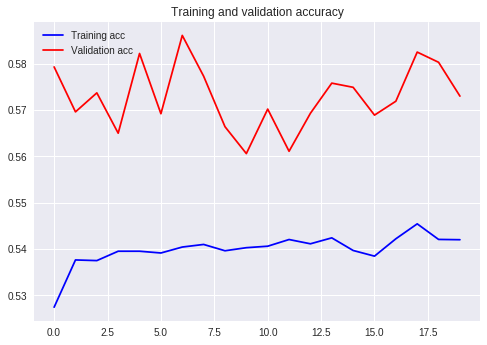

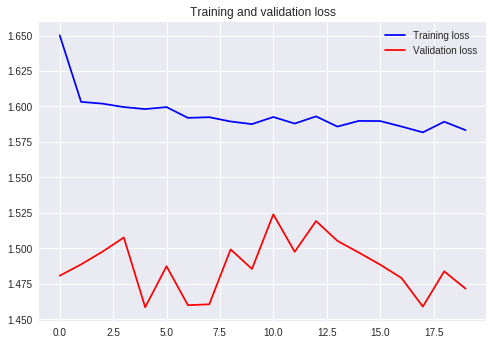

In [75]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epoch = range(len(acc))
 
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epoch, loss, 'b', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [76]:
scores = model_finetune.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 4s 400us/step
Test loss: 1.4716102521896361
Test accuracy: 0.573
